In [53]:
# importing the required libraries
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
import os
import logging
from PIL import Image
from tqdm import tqdm

In [54]:
# !unzip drive/MyDrive/PACS.zip &> /dev/null
# from PIL import Image

# Image.open('/content/kfold/cartoon/dog/pic_016.jpg').size

In [55]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [56]:
def initialize_model(num_classes, feature_extract = True, use_pretrained=True):
    model_ft = None
    input_size = 0

    model_ft = models.resnet18(pretrained=use_pretrained) #Using pretrained feature extractor 
    set_parameter_requires_grad(model_ft, feature_extract) #Setting .reuires_grad to False so that params remains fixed for feature extractor
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes) #Classifier

    return model_ft

feature_extract = True

model_ft = initialize_model( 7, feature_extract = True, use_pretrained=True) #for determining object class

lamda_param = torch.Tensor([0.43,0.23, 0.33]) # randomly initialized

# taking only those parameters that are to be optimized
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
    params_to_update.append(lamda_param)
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

	 fc.weight
	 fc.bias


In [57]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [58]:
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS

# Define datasets root
DIR_PHOTO = 'Homework3-PACS/PACS/photo'
DIR_ART = 'Homework3-PACS/PACS/art_painting'
DIR_CARTOON = 'Homework3-PACS/PACS/cartoon'
DIR_SKETCH = 'Homework3-PACS/PACS/sketch'

# means and standard deviations ImageNet because the network is pretrained
means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

transf = transforms.Compose([transforms.CenterCrop(224),  # Crops a central square patch of the image 224 because torchvision's AlexNet needs a 224x224 input!
                              transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                              transforms.Normalize(means,stds) # Normalizes tensor with mean and standard deviation
])

# Prepare Pytorch train/test Datasets
photo_dataset = torchvision.datasets.ImageFolder(DIR_PHOTO, transform=transf)
art_dataset = torchvision.datasets.ImageFolder(DIR_ART, transform=transf)
cartoon_dataset = torchvision.datasets.ImageFolder(DIR_CARTOON, transform=transf)
sketch_dataset = torchvision.datasets.ImageFolder(DIR_SKETCH, transform=transf)

# Check dataset sizes
print(f"Photo Dataset: {len(photo_dataset)}")
print(f"Art Dataset: {len(art_dataset)}")
print(f"Cartoon Dataset: {len(cartoon_dataset)}")
print(f"Sketch Dataset: {len(sketch_dataset)}")

Photo Dataset: 1670
Art Dataset: 2048
Cartoon Dataset: 2344
Sketch Dataset: 3929


In [59]:
BATCH_SIZE = 128 

# Dataloaders iterate over pytorch datasets 
photo_dataloader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
art_dataloader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=False)
cartoon_dataloader = DataLoader(cartoon_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=False)
sketch_dataloader = DataLoader(sketch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=False)

In [60]:
from sklearn.model_selection import train_test_split

def train_val_dataset(dataset, val_split=0.1):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    train_source_data = Subset(dataset, train_idx)
    val_source_data = Subset(dataset, val_idx)
    return train_source_data, val_source_data

l = []
l.append(photo_dataset)
l.append(art_dataset)
l.append(cartoon_dataset)
image_datasets = torch.utils.data.ConcatDataset(l)

train_source_data, val_source_data = train_val_dataset(image_datasets, val_split = 0.1)

#prepare train and val dataloader
train_dataloader = DataLoader(train_source_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_source_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = sketch_dataloader

In [61]:
def LossCE():
  return nn.CrossEntropyLoss()
def LossWeighted(lossce, sigma):
  sig_max = np.max(sigma)
  if sig_max>= 0.95:
    return sig_max * lossce
  else:
    return 0
def Hloss():
  return nn.CrossEntropyLoss()

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

loss1_list = []
loss2_list = []
loss3_list = []

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    if is_inception and phase == 'train':
                        
                        outputs = model(inputs)
                        sigma = F.softmax(outputs, dim=1)
                        sig_max = torch.max(sigma)
                        if sig_max >= 0.95:
                          loss2 = sig_max*criterion(outputs, labels)
                        else:
                          loss2 = 0
                        loss2_list.append(loss2)
                        loss1 = criterion(outputs, labels)
                        loss1_list.append(loss1)
                        loss3 = criterion(outputs, labels)
                        loss3_list.append(loss3)
                        loss = lamda_param[0]*loss1+lamda_param[1]*loss2+lamda_param[2]*loss3
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [65]:
model_ft, hist = train_model(model_ft, dataloaders, criterion = nn.CrossEntropyLoss(), optimizer = optimizer_ft, num_epochs=2, is_inception=True)

Epoch 0/1
----------
train Loss: 1.2502 Acc: 0.4077
val Loss: 1.1883 Acc: 0.6590

Epoch 1/1
----------
train Loss: 0.8098 Acc: 0.7503
val Loss: 0.8356 Acc: 0.8056

Training complete in 17m 25s
Best val Acc: 0.805601


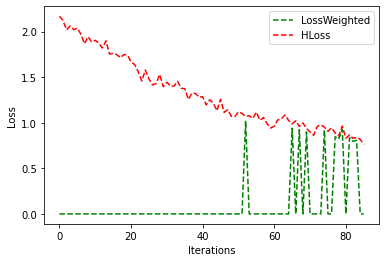

<Figure size 432x288 with 0 Axes>

In [70]:
# to make a graph tracking the status of individual loss components as the training progresses
def plotLosses( loss_2, loss_3, n_epochs=10, save_pic=True) : 
     epochs = range(n_epochs)
     plt.figure()
     plt.xlabel('Iterations')
     plt.ylabel('Loss')
     plt.plot(epochs, loss_2, 'g--', label="LossWeighted")
     plt.plot(epochs, loss_3, 'r--', label="HLoss")
     plt.legend()
     plt.show()
     if save_pic: 
          plt.savefig('losses.png')
     return

plotLosses( loss2_list, loss3_list, n_epochs=len(loss1_list), save_pic = True) 

In [78]:
# finding the test accuracy
running_corrects = 0
model_ft.eval()
acc_pro = []
for inputs, labels in test_loader:
  inputs = inputs.to(device)
  labels = labels.to(device)

  outputs = model_ft(inputs)
  _, preds = torch.max(outputs, 1)
  running_corrects += torch.sum(preds == labels.data)
  epoch_acc = running_corrects.double() / len(test_loader.dataset)

  acc_pro.append(epoch_acc)

print('Test Accuracy: {:.4f}'.format(acc_pro[-1]))

Test Accuracy: 0.2879
